# Sprint9課題 アンサンブル学習、グループワーク

## この課題の目的

- アンサンブル学習について理解する

## アンサンブル学習

3種類のアンサンブル学習の効果を小さめのデータセットで確認する。

- ブレンディング
- バギング
- スタッキング

### ライブラリ、モジュールの管理

In [1]:
# 演算
import numpy as np
import pandas as pd

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 機械学習
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# その他
import pprint

/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### 小さなデータセットの用意
以前も利用した回帰のデータセットを用意する。

[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使う。

train.csvを学習用（train）8割、検証用（val）2割に分割すること。

### データの準備

In [2]:
# import "House Prices" train data
df_origin = pd.read_csv("train.csv")

In [3]:
# 利用データを抽出する
columns = ['YearBuilt', 'GrLivArea', 'SalePrice']
df = df_origin[columns]

# 説明変数
X = df.drop("SalePrice", axis = 1)

# 目的変数
y = df["SalePrice"]

In [4]:
# データを分割する
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values)

### 標準化

In [ ]:
"""
説明変数
"""
# 学習用
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)

# 検証用
ss = StandardScaler()
ss.fit(X_test)
X_test_std = ss.transform(X_test)

"""
目的変数
"""
# 学習用
ss = StandardScaler()
ss.fit(y_train.reshape(-1,1))
y_train_std = ss.transform(y_train.reshape(-1,1))

# 検証用
ss = StandardScaler()
ss.fit(y_test.reshape(-1, 1))
y_test_std = ss.transform(y_test.reshape(-1,1))

### scikit-learn
単一のモデルはスクラッチ実装ではなく、scikit-learnなどのライブラリの使用を推奨する。

[sklearn.linear_model.LinearRegression — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

[sklearn.svm.SVR — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

[sklearn.tree.DecisionTreeRegressor — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

## 【問題1】ブレンディング
ブレンディングを実装し、単一モデルより精度が改善する例を最低3つ示すこと。

精度が改善するとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを示す。

ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法。（最も単純には平均をとる）

多様なモデルとは、以下のような条件を変化させることで作り出すもの。

- 手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
- ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
- 入力データの前処理の仕方（例：標準化、対数変換、PCAなど）

重要なのはそれぞれのモデルが大きく異なることであり、必ずしも単一モデルの精度が高い必要はない。

回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていない。

- 補足

分類問題の場合は、多数決を行う。
回帰問題に比べると複雑なため、scikit-learnにはVotingClassifierが用意されている。

[sklearn.ensemble.VotingClassifier — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

- 考察

どういった組み合わせが良いか、どのようにすると多様なモデルが作れるかを考えること。

### モデルの学習

In [6]:
print("X_train_std.shape : {}".format(X_train_std.shape))
print("y_train_std.shape : {}".format(y_train_std.shape))

X_train_std.shape : (1095, 2)
y_train_std.shape : (1095, 1)


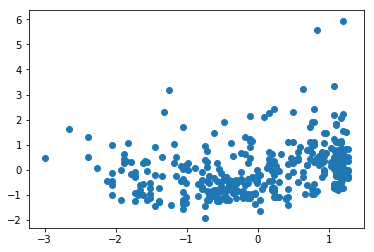

In [7]:
# 可視化
plt.scatter(X_test_std[:, 0], X_test_std[:, 1])

### パターン１：ハイパーパラメータをデフォルトに設定

In [8]:
RANDOM_STATE = 1

# 機械学習モデルをリストに格納
models = []
models.append(("LR", LinearRegression())) # ロジスティック回帰
models.append(("SVR", SVR())) # サポートベクターマシン
models.append(("DTR", DecisionTreeRegressor(random_state = RANDOM_STATE))) # 決定木

# 複数のclassifierの適用
names = [] # モデル名
preds = [] # 予測値
mses = [] # 平均二乗誤差
r2_list = [] # 決定係数

for name, model in models:
    model.fit(X_train_std, y_train_std) # 学習
    y_pred = model.predict(X_test_std).flatten() # 予測
    mse = np.round(mean_squared_error(y_test_std, y_pred),3) # 平均二乗誤差
    r2 = np.round(metrics.r2_score(y_test_std, y_pred),2)
    
    # リストに追加
    names.append(name)
    preds.append(y_pred)
    mses.append(mse)
    r2_list.append(r2)

# 結果の出力
for i in range(len(mses)):
    print("[classifier : {0}]  mse : {1}".format(names[i], mses[i]))

# ウェイトの生成（決定係数の比率をウェイトとする）
print("")
print("R2 : {}".format(r2_list))

weight = np.round(np.array(r2_list / sum(r2_list)).reshape(-1,1), 3)
print("")
print("model : {} / weight : {}".format(names, weight))

# 加重平均
ensemble_pred = np.dot(np.array(preds).T, weight)

# 平均二乗誤差
mse_ensemble = mean_squared_error(ensemble_pred, y_test_std)
print("")
print("[ensemble] mse : {}".format(np.round(mse_ensemble, 3)))
print("[ensemble] r2_score : {}".format(np.round(metrics.r2_score(y_test_std, ensemble_pred), 3)))

/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[classifier : LR]  mse : 0.335
[classifier : SVR]  mse : 0.3
[classifier : DTR]  mse : 0.58

R2 : [0.66, 0.7, 0.42]

model : ['LR', 'SVR', 'DTR'] / weight : [[0.371]
 [0.393]
 [0.236]]

[ensemble] mse : 0.279
[ensemble] r2_score : 0.721


- 各モデルの予測値を決定係数で重み付けした結果、MSEが改善した。

### パターン２：SVMのパラメーターを変更（kernel : "rbf")

ハイパーパラメータの"rbf"とは？

- Radial basis function kernelの略

- カーネル関数 ： $K(x, x')=\exp(-\gamma||x-x'||^2)$ where $\gamma=-\frac{1}{2\sigma^2}$

In [9]:
RANDOM_STATE = 1

# 機械学習モデルをリストに格納
models = []
models.append(("LR", LinearRegression())) # ロジスティック回帰
models.append(("SVR", SVR(kernel = "rbf"))) # サポートベクターマシン
models.append(("DTR", DecisionTreeRegressor(random_state = RANDOM_STATE))) # 決定木

# 複数のclassifierの適用
names = [] # モデル名
preds = [] # 予測値
mses = [] # 平均二乗誤差
r2_list = [] # 決定係数

for name, model in models:
    model.fit(X_train_std, y_train_std) # 学習
    y_pred = model.predict(X_test_std).flatten() # 予測
    mse = np.round(mean_squared_error(y_test_std, y_pred),3) # 平均二乗誤差
    r2 = np.round(metrics.r2_score(y_test_std, y_pred),2)
    
    # リストに追加
    names.append(name)
    preds.append(y_pred)
    mses.append(mse)
    r2_list.append(r2)

# 結果の出力
for i in range(len(mses)):
    print("[classifier : {0}]  mse : {1}".format(names[i], mses[i]))

# ウェイトの生成（決定係数の比率をウェイトとする）
print("")
print("R2 : {}".format(r2_list))

weight = np.round(np.array(r2_list / sum(r2_list)).reshape(-1,1), 3)
print("")
print("model : {} / weight : {}".format(names, weight))

# 加重平均
ensemble_pred = np.dot(np.array(preds).T, weight)

# 平均二乗誤差
mse_ensemble = mean_squared_error(ensemble_pred, y_test_std)

print("")
print("[ensemble] mse : {}".format(np.round(mse_ensemble, 3)))
print("[ensemble] r2_score : {}".format(np.round(metrics.r2_score(y_test_std, ensemble_pred), 3)))

[classifier : LR]  mse : 0.335
[classifier : SVR]  mse : 0.3
[classifier : DTR]  mse : 0.58

R2 : [0.66, 0.7, 0.42]

model : ['LR', 'SVR', 'DTR'] / weight : [[0.371]
 [0.393]
 [0.236]]

[ensemble] mse : 0.279
[ensemble] r2_score : 0.721


/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### パターン3：DTRのパラメーターを変更（max_depth : 3)

In [45]:
RANDOM_STATE = 1

# 機械学習モデルをリストに格納
models = []
models.append(("LR", LinearRegression())) # ロジスティック回帰
models.append(("SVR", SVR())) # サポートベクターマシン
models.append(("DTR", DecisionTreeRegressor(max_depth = 4, random_state = RANDOM_STATE))) # 決定木

# 複数のclassifierの適用
names = [] # モデル名
preds = [] # 予測値
mses = [] # 平均二乗誤差
r2_list = [] # 決定係数

for name, model in models:
    model.fit(X_train_std, y_train_std) # 学習
    y_pred = model.predict(X_test_std).flatten() # 予測
    mse = np.round(mean_squared_error(y_test_std, y_pred),3) # 平均二乗誤差
    r2 = np.round(metrics.r2_score(y_test_std, y_pred),3)
    
    # リストに追加
    names.append(name)
    preds.append(y_pred)
    mses.append(mse)
    r2_list.append(r2)

# 結果の出力
for i in range(len(mses)):
    print("[classifier : {0}]  mse : {1}".format(names[i], mses[i]))

# ウェイトの生成（決定係数の比率をウェイトとする）
print("")
print("R2 : {}".format(r2_list))

#weight = np.array([0.2, 0.6, 0.2])
weight = np.round(np.array(r2_list / sum(r2_list)).reshape(-1,1), 3)
print("")
print("model : {} / weight : {}".format(names, weight))

# 加重平均
ensemble_pred = np.dot(np.array(preds).T, weight)

# 平均二乗誤差
mse_ensemble = mean_squared_error(ensemble_pred, y_test_std)
print("")
print("[ensemble] mse : {}".format(np.round(mse_ensemble, 3)))
print("[ensemble] r2_score : {}".format(np.round(metrics.r2_score(y_test_std, ensemble_pred), 3)))

[classifier : LR]  mse : 0.335
[classifier : SVR]  mse : 0.3
[classifier : DTR]  mse : 0.307

R2 : [0.665, 0.7, 0.693]

model : ['LR', 'SVR', 'DTR'] / weight : [[0.323]
 [0.34 ]
 [0.337]]

[ensemble] mse : 0.277
[ensemble] r2_score : 0.723


/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- いずれのパターンでもスコアは改善が見られた。

## 【問題2】バギング
バギングを実装し、単一モデルより精度があがる例を最低1つ示すこと。

バギングは入力データの選び方を多様化する方法である。

学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ブートストラップサンプル）を作り出す。

それらによってモデルをN個学習し、推定結果の平均をとる。

ブレンディングと異なり、それぞれの重み付けを変えることはない。

[sklearn.model_selection.train_test_split — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができる。

これによりブートストラップサンプルが手に入る。

推定結果の平均をとる部分はブースティングと同様の実装になる。

## バギング実施前

In [ ]:
RANDOM_STATE = 1

models = []
models.append(("lr", LinearRegression())) # 線形回帰
models.append(("svr", SVR())) # サポートベクターマシン
models.append(("dtr", DecisionTreeRegressor(random_state = RANDOM_STATE)))# 決定木

# 結果を格納するリスト
names = [] # モデルの種類
mses = [] # 平均二乗誤差

# モデル別にアンサンブル学習を実施
for name, model in models:
    print("")
    names.append(name)
    
    model.fit(X_train_std, y_train_std) # 学習
    y_pred = model.predict(X_test_std) # 予測
    mse = metrics.r2_score(y_test_std, y_pred)
    mses.append(mse)

In [12]:
# バギングしない場合のMSE
for name, mse in zip(names, mses):
    print("name : {}  / mse : {}".format(name, np.round(mse, 3)))

name : lr  / mse : 0.665
name : svr  / mse : 0.7
name : dtr  / mse : 0.42


- バギングにより、上記のMSE（平均二乗誤差）が低下すれば良い。

## バギング実施後 : データセットを5分割

In [ ]:
# データのサブセットを格納するリスト
X_train_std_sub = []
y_train_std_sub = []

# パラメーター
N = 10 # サブセットの数
train_size = 0.8 # 分割の割合

# サブセットを作成
for i in range(N):
    X_sub, _ ,y_sub, _ = train_test_split(X_train_std, y_train_std, train_size = train_size, shuffle = True)
    X_train_std_sub.append(X_sub) # 学習用データ（説明変数）
    y_train_std_sub.append(y_sub) # 学習用データ（目的変数）

In [ ]:
RANDOM_STATE = 1

models = []
models.append(("lr", LinearRegression())) # 線形回帰
models.append(("svr", SVR())) # サポートベクターマシン
models.append(("dtr", DecisionTreeRegressor(random_state = RANDOM_STATE)))# 決定木


# 結果を格納するリスト
names = [] # モデルの種類
ensemble_preds = [] # 予測値
ensemble_mses = [] # 平均二乗誤差

# モデル別にアンサンブル学習を実施
for name, model in models:
    print("")
    names.append(name)
    sum_pred = 0 # 予測値を0で初期化
    mse_list = []
    
    for i in range(N):
        model.fit(X_train_std_sub[i], y_train_std_sub[i]) # 学習
        y_pred = model.predict(X_test_std) # 予測
        mse = metrics.r2_score(y_test_std, y_pred)
        mse_list.append(mse)
        
        sum_pred += y_pred
    
    # アンサンブル学習結果（予測値の平均）
    ensemble_pred = sum_pred / N
    ensemble_preds.append(ensemble_pred)
    
    # 平均二乗誤差
    ensemble_mse = mean_squared_error(y_test_std, ensemble_pred) 
    ensemble_mses.append(ensemble_mse)

In [118]:
# バギング時のMSE
for name, ensemble_mse in zip(names, ensemble_mses):
    print("name : {}  / ensemble_mse : {}".format(name, np.round(ensemble_mse, 3)))

name : lr  / ensemble_mse : 0.335
name : svr  / ensemble_mse : 0.308
name : dtr  / ensemble_mse : 0.397


- 線形回帰、サポートベクターマシンはMSEが大幅に下がった一方、決定木は微増となった。

## 【問題3】スタッキング
スタッキングを実装し、単一モデルより精度があがる例を最低1つ示すこと。

スタッキングの手順は以下の通り。

最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装する。

まずは$K_0 = 3$, $M_0 =2$程度にする。

### 学習時

（ステージ $0$ ）

- 学習データを$K_0$個に分割する。

- 分割した内の$(K_0 −1)$個をまとめて学習用データ、残り 1個を推定用データとする組み合わせが$K_0$個作れる。

- あるモデルのインスタンスを $K_0$個用意し、異なる学習用データを使い学習する。

- それぞれの学習済みモデルに対して、使っていない残り$1$個の推定用データを入力し、推定値を得る。（これをブレンドデータと呼ぶ）

- さらに、異なるモデルのインスタンスも $K_0$個用意し、同様のことを行う。モデルが 
$M_0$個あれば、 $M_0$個のブレンドデータが得られる。


（ステージ $n$ ）

- ステージ$ n−1$のブレンドデータを
$M_{n−1}$次元の特徴量を持つ学習用データと考え、 $K_n$個に分割する。以下同様である。

（ステージ N）＊最後のステージ

- ステージ $N−1$ の$ M_{N−1}$個のブレンドデータを$M_{N−1}$次元の特徴量の入力として、1種類のモデルの学習を行う。

    これが最終的な推定を行うモデルとなる。

### 推定時

（ステージ 0 ）

- テストデータを$K_0$×$M_0$個の学習済みモデルに入力し、$K_0$×$M_0$個の推定値を得る。

    これを $K_0$の軸で平均値を求め $M_0$次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $n$）

- ステージ $n−1$で得たブレンドテストを $K_n$×$M_n$ 個の学習済みモデルに入力し、$K_n$×$M_n$個の推定値を得る。

    これを $K_n$の軸で平均値を求め $M_0$次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）

（ステージ $N$）＊最後のステージ

- ステージ $N−1$で得たブレンドテストを学習済みモデルに入力し、推定値を得る。

**以下、モデルの作成、学習、推定を行う。**

### 学習

In [6]:
class brend:
    """
    ブレンドデータを格納するクラス
    
    Attributes
    ----------
    self.name : str
        モデルの種類
        
    self.model_list : list
        学習したモデル
    
    self.brend_data : instance
        モデルのインスタンス
    
    """
    
    def __init__(self, ):
        self.name = None # モデルの名称
        self.model_list = []# インスタンス
        self.brend_data = [] # ブレンドデータ

In [7]:
K = 3 # 分割数

KERNEL = "rbf"
RANDOM_STATE = 1 # 乱数生成のシード値
MAX_DEPTH = 3 # 決定木の深さ

MODEL_CHOICE = 0 # モデルの番号

BASE_MODELS = [LinearRegression(), SVR(kernel = KERNEL), DecisionTreeRegressor(random_state = RANDOM_STATE)] # ステージ１で用いるモデル

In [8]:
kf = KFold(n_splits=K, random_state=RANDOM_STATE, shuffle=True)

# データを分割
X_train_list = []
X_remain_list = []
y_train_list = []
y_remain_list = []
    
for train_index, remain_index in kf.split(X_train_std, y_train_std):
    X_train_list.append(X_train_std[train_index])
    X_remain_list.append(X_train_std[remain_index])
    y_train_list.append(y_train_std[train_index])
    y_remain_list.append(y_train_std[remain_index])

In [9]:
X_train_std.shape, y_train_std.shape

((1095, 2), (1095, 1))

### ステージ０

In [10]:
# 用いるモデルのインスタンスを格納する
model_list = []

In [11]:
model_list.append(("lr", LinearRegression()))
model_list.append(("svr", SVR()))
model_list.append(("dtr", DecisionTreeRegressor(max_depth = MAX_DEPTH, random_state = RANDOM_STATE)))

In [12]:
model_list

[('lr',
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)),
 ('svr',
  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
 ('dtr', DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=1, splitter='best'))]

In [13]:
# ブレンドデータの格納
brend_results = []
brend_data = []

In [ ]:
for num in range(len(model_list)):
    name = model_list[num][0]
    model = model_list[num][1]


    for i in range(K):
        
        brending = brend()
        brending.name = name
        
        # 学習
        model.fit(X_train_list[i], y_train_list[i])
        brending.model_list.append(model)        
        
        # 予測（ブレンドデータの生成）
        brend_data = model.predict(X_remain_list[i]).flatten()
        brending.brend_data.append(brend_data)
        
        # リストに格納
        brend_results.append(brending)

### ステージ1

- ステージ０で生成したブレンドデータ、および正解値を用いてモデルを生成する。

In [16]:
# ステージ1での学習、予測に用いるモデル
model_for_pred = BASE_MODELS[MODEL_CHOICE]

In [17]:
# ステージ0で生成したブレンドデータに基づき予測を実行する
brend_for_train = []

# 各ブレンドデータの算出結果について実行する
for i in range(len(brend_results)):
    brend_for_train.append(np.hstack(brend_results[i].brend_data))

In [18]:
# ステージ１の学習用データ（特徴量）
np.array(brend_for_train).shape

(9, 365)

In [19]:
# ステージ１の学習用データ（正解ラベル）
y_train_for_stage1 = np.array(y_remain_list)
y_train_for_stage1.shape

(3, 365, 1)

In [20]:
y_train_for_stage1 = y_train_for_stage1.reshape(y_train_for_stage1.shape[0], y_train_for_stage1.shape[1])
y_train_for_stage1.shape

(3, 365)

In [21]:
tmp = np.array([y_train_for_stage1 for i in range(K)])
tmp.shape

(3, 3, 365)

In [22]:
y_train_for_stage1 = tmp.reshape(tmp.shape[0]*tmp.shape[1], tmp.shape[2])
y_train_for_stage1.shape

(9, 365)

In [23]:
# 学習用のブレンドデータの生成
brend_data_for_train = np.array(brend_for_train).flatten()[:, np.newaxis]

In [24]:
brend_data_for_train.shape

(3285, 1)

In [25]:
# フェーズ１で用いるモデルを生成
#model_for_pred.fit(brend_data_for_train, y_train_std)
model_for_pred.fit(brend_data_for_train, y_train_for_stage1.flatten()[:, np.newaxis])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## 予測

### ステージ０

In [26]:
print("X_test_std.shape : {}".format(X_test_std.shape))
print("y_test_std.shape : {}".format(y_test_std.shape))

X_test_std.shape : (365, 2)
y_test_std.shape : (365, 1)


In [27]:
# ステージ０の学習で生成したモデルを用いてブレンドデータを生成する
#brend_test = []
pred_result = []

for brend_result in brend_results:
    for i in range(len(brend_result.model_list)):
        pred_result.append(brend_result.model_list[i].predict(X_test_std).flatten())
        
# 平均値
brend_test = np.mean(pred_result, axis = 0)

In [28]:
brend_test.shape

(365,)

### ステージ１の予測

In [29]:
# 予測用のブレンドデータを生成
brend_test_final = brend_test[:, np.newaxis]
brend_test_final.shape

(365, 1)

In [30]:
# 予測
y_pred_stack = model_for_pred.predict(brend_test_final).flatten()

### 予測結果の評価

In [31]:
# 決定係数
r2_stack = metrics.r2_score(y_test_std, y_pred_stack)
r2_stack

0.6810858825124876

Text(0,0.5,'pred')

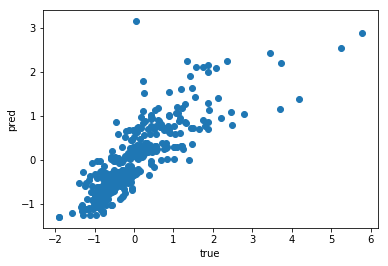

In [32]:
# 散布図
plt.scatter(y_test_std, y_pred_stack)
plt.xlabel("true")
plt.ylabel("pred")

In [33]:
# 平均二乗誤差
mse_stack = mean_squared_error(y_test_std, y_pred_stack)
mse_stack

0.3189141174875124

In [34]:
# 誤差
error = y_test_std.flatten() - y_pred_stack

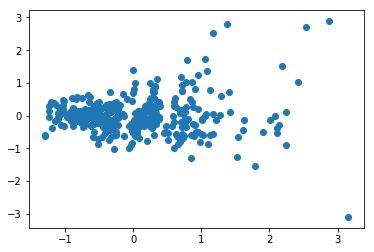

In [35]:
# 残差プロット
plt.scatter(y_pred_stack, error)

In [36]:
RANDOM_STATE = 1

# 機械学習モデルをリストに格納
models = []
models.append(("LR", LinearRegression())) # ロジスティック回帰
models.append(("SVR", SVR())) # サポートベクターマシン
models.append(("DTR", DecisionTreeRegressor(random_state = RANDOM_STATE))) # 決定木

# 複数のclassifierの適用
names = [] # モデル名
preds = [] # 予測値
mses = [] # 平均二乗誤差
r2_list = [] # 決定係数

for name, model in models:
    model.fit(X_train_std, y_train_std) # 学習
    y_pred = model.predict(X_test_std).flatten() # 予測
    mse = np.round(mean_squared_error(y_test_std, y_pred),3) # 平均二乗誤差
    r2 = np.round(metrics.r2_score(y_test_std, y_pred),2)
    
    # リストに追加
    names.append(name)
    preds.append(y_pred)
    mses.append(mse)
    r2_list.append(r2)

# 結果の出力
for i in range(len(mses)):
    print("[classifier : {0}]  mse : {1}".format(names[i], mses[i]))

print("")
    
for i in range(len(mses)):
    print("[classifier : {0}]  r2_score : {1}".format(names[i], r2_list[i]))

[classifier : LR]  mse : 0.378
[classifier : SVR]  mse : 0.295
[classifier : DTR]  mse : 0.59

[classifier : LR]  r2_score : 0.62
[classifier : SVR]  r2_score : 0.71
[classifier : DTR]  r2_score : 0.41


/Users/makintosh/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
mse_stack, r2_stack

(0.3189141174875124, 0.6810858825124876)

今回、stage1で用いた線形回帰モデルに関して考察する。

- 平均二乗誤差（mse）：単一モデルが0.378に対して、スタッキング時は0.318と改善した。
- 決定係数（r2_score）：単一モデルが0.62に対して、スタッキング時は0.68と改善した。

### Take away

ブレンディング、バギング、スタッキングのスクラッチ実装を通じて、アンサンブル学習に対する理解が深まった。

- 今回は３種類のモデル（線形回帰、サポートベクターマシン、決定木）を用いたが、大前提として"万能なモデルは存在せず"、各モデルの特徴（得意・不得意）を認識する必要がある。


- モデルの精度は、学習に用いるデータセットに依存することにも留意が必要。（あるデータセットに対して当てはまりの良いモデルもあれば、そうでないモデルもある）


- データセットが与えられた際には、データに対して適切な前処理を施した上で、複数のモデルによる学習、推定を行うことが肝要である。


- 尚、今回扱わなかったランダムフォレストは、決定木は「層を深くするほど過剰適合を起こしやすい」という欠点をアンサンブル学習により克服する手法である。
    - 具体的には、複数パターンでランダムサンプリングしたサンプルに対して決定木モデルを学習し、多数決により分離境界、予測値を決めるもの。